# Numerical Solutions to ODEs

### Basic Python Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Our goal here is to explore the python implementations of ODE solvers we discussed in class. To see the basic idea, let's start with 1d harmonic oscilator 

$$\ddot x + \gamma \dot x + \omega_0^2 x = 0$$

The way we solve this problem is to write it as a system of first order equations

$$\dot x = v$$

$$\dot v = -\gamma v - \omega_0^2 x$$

So we have two variables, position $x$ and velocity $v$, that both evolve according to first order ODEs but their evolution is coupled ($\dot v$ depends on $x$). We now define a function that computes these derivatives in the form of an array:

In [2]:
def derivative(X,t,gamma=1,omega_0=10): ## X is the array [x,v]
        ## notice that we need to use t as an argument even though we don't use it
    return np.array([X[1],-gamma*X[1]-omega_0**2*X[0]]) ## return the array dot X defined by our equation

In [3]:
from scipy import integrate

In [4]:
t_R=np.linspace(0,10,1000) # range of time we want to solve
X0=[3.,0]     #initial conditions

In [5]:
sol1=integrate.odeint(derivative,X0,t_R)  #syntax - odeint(derivative,initial conditon, time)

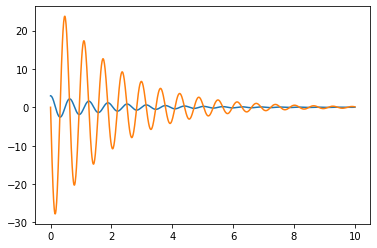

In [6]:
plt.plot(t_R,sol1[:,0])  # returns solution for X at each point in time  sol[:,0] is x(t)
plt.plot(t_R,sol1[:,1])  # returns solution for X at each point in time  sol[:,1] is v(t)
plt.show()

Since we have both the position and velocity, we can also just plot the evolution in phase space:

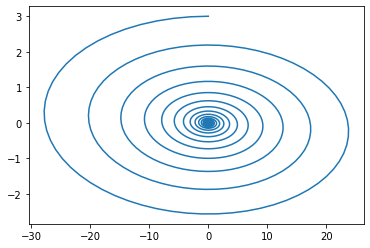

In [7]:
plt.plot(sol1[:,1],sol1[:,0])  #phase space plot
plt.show()

I secretly planned ahead when I derived my derivative function.  Because odtint takes a function as input, you can pass any of the variabels that the function defines.  This goes under the "args" option, where we pass this additional information

In [8]:
sol2=integrate.odeint(derivative,X0,t_R,args=(2,3)) # now passing gamma=2 and omega_0=20

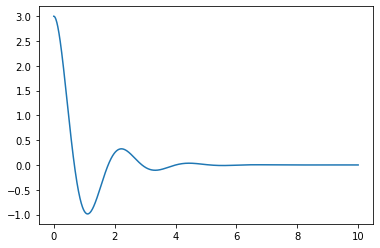

In [9]:
plt.plot(t_R,sol2[:,0])  # returns solution for X at each point in time  sol[:,0] is x(t)
plt.show()

ODE libraries like odeint don't always tell you what they are doing. It uses adaptive steps and error estimation to try to keep the solution under control. This is obviously useful, but it also means that we have less of an understanding what's happening if something goes wrong.

There are other ODE integrators that tell you very specifically what method they are using. The syntax for the derivatives vary for different integrators, so first we define the derivative in the reverse order

In [10]:
def d2(t,X,gamma=1,omega_0=10): ## X is the array [x,v]
        ## notice that we need to use t as an argument even though we don't use it
    return np.array([X[1],-gamma*X[1]-omega_0**2*X[0]]) ## return the array dot X defined by our equation

Now we will use solve_ivp, which uses the 4th order Rugga-Kutta as a default

In [11]:
sol3=integrate.solve_ivp(d2,[0,10],X0) 

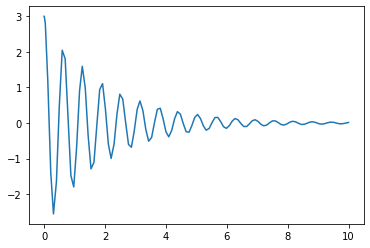

In [12]:
plt.plot(sol3['t'],sol3['y'][0,:])

### Numeric Stability

We studied $A$-stability in class, which we defined via solutions to the equation $\dot x = \lambda x$ for ${\rm Re}\lambda < 0$.

We can definitely check stability if we write our own version of this method. To make it easy, we can use the Euler method:

In [13]:
def Euler(D,dt,x0,npoints):
    out=x0*np.ones(npoints) #I am only implementing the 1d version
    for i in range(npoints-1):
        out[i+1]=out[i]+dt*D(i*dt,out[i])
    return out

Let's check that it works for $\lambda =-0.1$ and $dt = 0.1$.

In [14]:
Astb1=Euler(lambda t,x:-0.1*x,0.1,10,1000)
t1=np.arange(0,100,0.1)

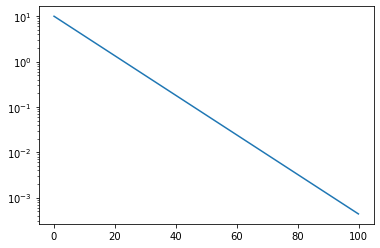

In [15]:
plt.plot(t1,Astb1)
plt.yscale('log')

Our stability analysis of this method showed that we require $|1+dt \lambda|<1$ so if we take $\lambda = -2$ and $dt =1.01$ we should find that it is unstable:

In [16]:
Astb2=Euler(lambda t,x:-2*x,1.01,10,100)
t2=np.arange(0,101,1.01)

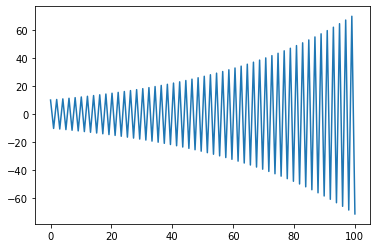

In [17]:
plt.plot(t2,Astb2)

Of course we can just make the step smaller to recover the correct behavior

In [18]:
Astb3=Euler(lambda t,x:-2*x,0.8,10,20)
t3=np.arange(0,16,0.8)
Astb4=Euler(lambda t,x:-2*x,0.4,10,40)
t4=np.arange(0,16,0.4)

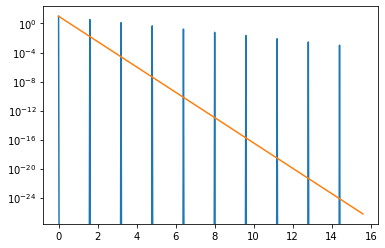

In [19]:
plt.plot(t3,Astb3)
plt.plot(t4,Astb4)
plt.yscale('log')
plt.show()

Notice that stability does not imply that it is a accurate solution. Both choices of $dt$ chosen above are stable, but only one is accurate.

With the built in python libraries, we don't have explicit control over the step size and therefore it is hard to see explicitely where the boundary between stable and unstable lies. However, we know that an explicit Runga-Kutta was a finite region of stability and one might therefore expect to see some sign of this instability when we use solve_ivp with the RG method. In contrast, odeint switches between methods, presumably to avoid these kinds of pitfalls.

In [20]:
Astb_ivp=integrate.solve_ivp(lambda t,x:-10*x,[0,20],[10]) 
Astb_ode=integrate.odeint(lambda x,t:-10*x,10,np.arange(0,20,0.1)) 

In [21]:
Astb_ivp['y'].shape

(1, 74)

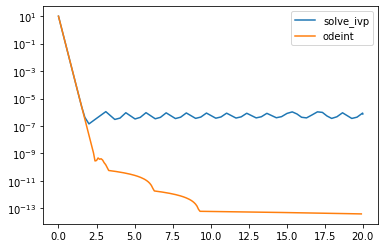

In [22]:
plt.plot(Astb_ivp['t'],np.abs(Astb_ivp['y'][0,:]),label='solve_ivp')
plt.plot(np.arange(0,20,0.1),np.abs(Astb_ode),label='odeint')
plt.yscale('log')
plt.legend()
plt.show()

We see that solve_ivp fails earlier, producing a larger error. odeint tracks the correct solution for longer, but also gets stuck at a non-zero value rather than continuing to zero as it should.

One of the interesting features we notice is that it has more to do with the size of $x$ and not the value of the $\lambda$. This is not what we would expect from our A-stability arguements.

In [23]:
Astb_ivp2=integrate.solve_ivp(lambda t,x:-0.5*x,[0,100],[10]) 
Astb_ode2=integrate.odeint(lambda x,t:-0.5*x,10,np.arange(0,100,0.1)) 

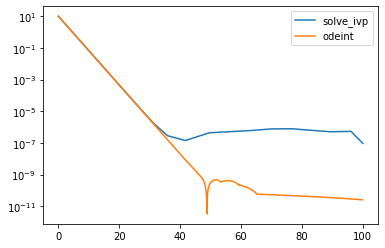

In [24]:
plt.plot(Astb_ivp2['t'],np.abs(Astb_ivp2['y'][0,:]),label='solve_ivp')
plt.plot(np.arange(0,100,0.1),np.abs(Astb_ode2),label='odeint')
plt.yscale('log')
plt.legend()
plt.show()

If we thought of these as example of fixed $dt$ RK algorithms, this behavior would make no sense. The stability of this equation according to our analysis should be independent of the value of $x$. For this particular equation, a fixed RK would simply multiply the previous step by a constant, so it seems surprising that this doesn't continue towards zero.

However, most ode integrators you encounter are adaptive. They choose step sizes and other setting to track the solutions to a certain accuracy. There are two kinds of measurements of accuracy: relative error tolerance (rtol) and absolute error tolerance (atol). Relative error is like the fractional error where absolute error is the total error. Most importantly, what the algorithm will actually tolerate is the largest of the two max(rtol,atol).

The default for atol is 1e-6, which means that when $x < 10^{-6}$ the default absolute error tolerance is going to be satisfied and it will put up with pretty much anything. Therefore, we key to get a more accurate answer is to lower atol. We can leave rtol at its default value, 1e-3, because the relative error isn't causing us any trouble.


In [25]:
ivp_hp=integrate.solve_ivp(lambda t,x:-0.5*x,[0,100],[10],rtol=1e-3,atol=1e-19) 
ode_hp=integrate.odeint(lambda x,t:-0.5*x,10,np.arange(0,100,0.1),mxstep=200,rtol=1e-3,atol=1e-19) 

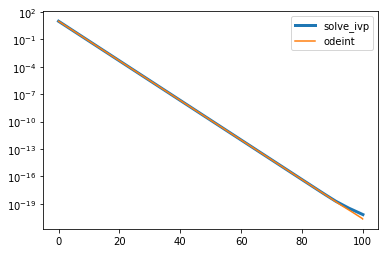

In [26]:
plt.plot(ivp_hp['t'],np.abs(ivp_hp['y'][0,:]),lw=3,label='solve_ivp')
plt.plot(np.arange(0,100,0.1),np.abs(ode_hp),label='odeint')
plt.yscale('log')
plt.legend()
plt.show()